<a href="https://colab.research.google.com/github/Tifou-Kerdjou/deep-learning/blob/main/DenseNet_indian_pines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 %tensorflow_version 1.0
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D
from keras.layers import MaxPool2D, AvgPool2D, GlobalAvgPool2D, BatchNormalization,GlobalAveragePooling2D
from keras.layers import Concatenate, ReLU,Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import preprocessing
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
from sklearn.metrics import classification_report, confusion_matrix

from keras.utils import np_utils
import numpy as np
import scipy.io
import time

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
!wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
#!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
#!wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2022-02-17 16:54:08--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2022-02-17 16:54:08 (139 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]

--2022-02-17 16:54:08--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   760KB/s    in 8.5s    

2022-02-17 16:54:17 (681 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]



In [3]:
# load data 
def loadPaviauData():
    data = scipy.io.loadmat('PaviaU.mat')['paviaU']
    labels = scipy.io.loadmat('PaviaU_gt.mat')['paviaU_gt']
    
    return data, labels

def loadIndianPinesData():
    data = scipy.io.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    
    return data, labels
# all the preprocessing needed in my work 
# i used 80% for test and 20% training
def splitTrainTestSet(X, y, testRatio=0.80):
     x_train = []
     y_train = []
     x_test = []
     y_test = []

     rs = ShuffleSplit(n_splits=1, test_size=testRatio, random_state=70)
     for train_index, test_index in rs.split(X):
           x_train.append(X[train_index])
           x_test.append(X[test_index])
        
     for train_index, test_index in rs.split(y):
           y_train.append(y[train_index])
           y_test.append(y[test_index])
     x_train = np.asarray(x_train)[0]
     y_train = np.asarray(y_train)[0]
     x_test = np.asarray(x_test)[0]
     y_test = np.asarray(y_test)[0]
     return x_train, x_test, y_train, y_test

def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [4]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [5]:
numPCAComponents = 30
windowSize = 15
testRatio = 0.9

In [6]:
X, y = loadIndianPinesData()
#X,pca = applyPCA(X,numPCAComponents)
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)

#_,x_val, _,y_val = train_test_split(X_test,y_test,test_size=0.20,random_state=70)
#X_train, y_train = oversampleWeakClasses(X_train, y_train)
#X_train = AugmentData(X_train)

_,x_val, _,y_val = train_test_split(X_test,y_test,test_size=0.20,random_state=70)



In [7]:
# Reshape into (numberofsamples, channels, height, width)
#X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))

# convert class labels to on-hot encoding

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)
# Define the input shape 




input_shape= X_train[0].shape
print(input_shape)

(15, 15, 200)


In [8]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 2, 3, 3, 3
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAveragePooling2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [9]:
def densenet_D(img_shape, f=32):
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x= Dropout(0.5)(x)
    return x
  
  
  def dense_block(tensor, k,r):
    for _ in range(r):
      x = bn_rl_conv(tensor, f , k)
      tensor = Concatenate()([tensor, x])
    x = AvgPool2D((3,3), strides=3, padding='same')(tensor)    
    return x

  
  input = Input(img_shape)
  
  x = Conv2D(128, 1, strides=1, padding='same')(input)
  x = ReLU()(x)
  
  x1 = dense_block(x,1,3)
  x2 = dense_block(x,3,3)
  x = Concatenate()([x1, x2])
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(64,1, strides=1, padding='same')(x)
  x = dense_block(x,1,3)
  
  x = BatchNormalization()(x)
  x = ReLU()(x)
  
  
  x = GlobalAveragePooling2D()(x)
  #x= Flatten()(x)
# output = Dense(n_classes, activation='linear',W_regularizer=l2(0.01))(x)
  output = Dense(n_classes, activation='softmax')(x)
  model = Model(input, output)
  return model
  #return  x

In [10]:
from keras import optimizers
import tensorflow as tf

from keras.callbacks import ModelCheckpoint 

mcp_save = ModelCheckpoint('model.hdf5', save_best_only=True, monitor='val_loss', mode='min',period=20)
sgd = optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, amsgrad=False)
input_shape =  windowSize, windowSize, 200
n_classes = 16
model = densenet_D(input_shape, n_classes)

model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer=sgd)
model.summary()
debut = time.time()
time_callback = TimeHistory()
hist1=model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=[x_val,y_val],validation_freq=10,callbacks=[mcp_save,time_callback] )

times = time_callback.times

print("temp du epoch = {}".format(times))
sgd = optimizers.Adam(lr=0.00003, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer=sgd)
hist2=model.fit(X_train,y_train,batch_size=32,epochs=200,validation_data=[x_val,y_val],validation_freq=20,callbacks=[mcp_save])
sgd = optimizers.Adam(lr=0.000003, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer=sgd)
hist3=model.fit(X_train,y_train,batch_size=32,epochs=250,validation_data=[x_val,y_val],validation_freq=20,callbacks=[mcp_save])
fin = time.time()
print("temp du entrenement = {}".format(fin-debut))
model.load_weights("model.hdf5")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 15, 200)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 15, 128)  25728       input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 15, 15, 128)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 15, 15, 128)  512         re_lu_1[0][0]                    
__________

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1024/1024 [==============================] - 1s 1ms/step - loss: 0.4585 - accuracy: 0.9102
Epoch 12/200
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4622 - accuracy: 0.8994
Epoch 13/200
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4364 - accuracy: 0.9111
Epoch 14/200
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4441 - accuracy: 0.9102
Epoch 15/200
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4439 - accuracy: 0.9102
Epoch 16/200
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4372 - accuracy: 0.9150
Epoch 17/200
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4287 - accuracy: 0.9141
Epoch 18/200
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4268 - accuracy: 0.9199
Epoch 19/200
1024/1024 [==============================] - 2s 2ms/step - loss: 0.4212 - accuracy: 0.9229
Epoch 20/200
1024/1024 [==============================] - 3s 3ms/step - loss:

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1024/1024 [==============================] - 2s 1ms/step - loss: 0.0957 - accuracy: 0.9863
Epoch 12/250
1024/1024 [==============================] - 2s 2ms/step - loss: 0.1010 - accuracy: 0.9814
Epoch 13/250
1024/1024 [==============================] - 2s 2ms/step - loss: 0.0932 - accuracy: 0.9834
Epoch 14/250
1024/1024 [==============================] - 2s 2ms/step - loss: 0.1061 - accuracy: 0.9795
Epoch 15/250
1024/1024 [==============================] - 2s 2ms/step - loss: 0.0981 - accuracy: 0.9834
Epoch 16/250
1024/1024 [==============================] - 2s 2ms/step - loss: 0.0899 - accuracy: 0.9834
Epoch 17/250
1024/1024 [==============================] - 2s 2ms/step - loss: 0.0906 - accuracy: 0.9912
Epoch 18/250
1024/1024 [==============================] - 2s 2ms/step - loss: 0.1003 - accuracy: 0.9795
Epoch 19/250
1024/1024 [==============================] - 2s 2ms/step - loss: 0.0940 - accuracy: 0.9863
Epoch 20/250
1024/1024 [==============================] - 3s 3ms/step - loss:

OSError: ignored

In [ ]:


#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[3], X_test.shape[1], X_test.shape[2]))

In [11]:
print(X_test[0].shape)

(15, 15, 200)


In [ ]:
#model.fit(X_train,y_train,batch_size=16,epochs=30)

In [ ]:

#Y_pred = model.predict(X_test)
#y_pred = np.argmax(Y_pred, axis=1)
#target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
#               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
#                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
#               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
#               'Stone-Steel-Towers']

    
#classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
#confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
#score = model.evaluate(X_test, y_test, batch_size=128)
#Test_Loss =  score[0]*100
#Test_accuracy = score[1]*100


In [ ]:
#print(hist.history)

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

avg_acc = (np.mean(hist1.history["accuracy"])+np.mean(hist2.history["accuracy"])+np.mean(hist3.history["accuracy"]))/3
print(" AA = {}".format(avg_acc))
debut = time.time()
y_pred = model.predict(X_test)
fin = time.time()
print("temp du test = {}".format(fin-debut))
Y_test = np.argmax(y_test, axis=1)
print(classification_report(Y_test, np.argmax(y_pred,axis=1)))

cm = confusion_matrix(Y_test, np.argmax(y_pred,axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

pclass = cm.diagonal()

print(pclass)


oa = np.mean(pclass) 

print("OA = {}".format(oa))

cohen_score = cohen_kappa_score(Y_test, np.argmax(y_pred,axis=1))
print("kappa = {}".format(cohen_score))

 AA = 0.8864472707112631
temp du test = 6.309812545776367
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.91      0.99      0.95      1268
           2       0.98      0.95      0.97       741
           3       1.00      0.94      0.97       215
           4       0.93      0.94      0.94       435
           5       0.96      0.95      0.96       667
           6       0.00      0.00      0.00        27
           7       1.00      1.00      1.00       428
           8       1.00      0.18      0.30        17
           9       0.91      0.97      0.94       870
          10       0.99      0.97      0.98      2224
          11       0.97      0.93      0.95       535
          12       0.97      0.98      0.98       188
          13       0.98      1.00      0.99      1130
          14       0.99      0.96      0.97       351
          15       0.96      0.79      0.86        84

    accuracy          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


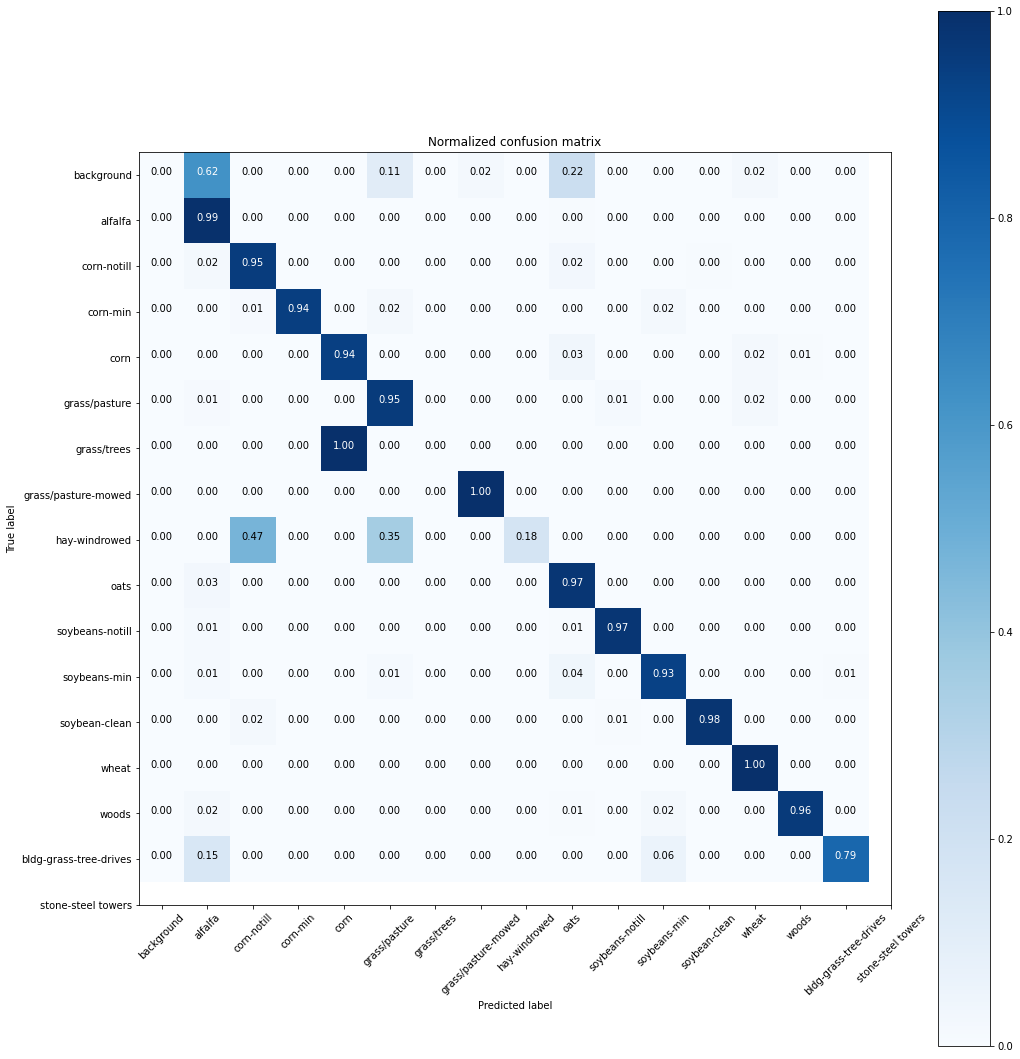

In [13]:
import itertools
import matplotlib.pyplot as plt
indianpines_class_names = ['background',
                           'alfalfa',           'corn-notill',               'corn-min',               'corn',
                           'grass/pasture',     'grass/trees',    'grass/pasture-mowed',      'hay-windrowed',
                           'oats',          'soybeans-notill',           'soybeans-min',      'soybean-clean',
                           'wheat',                   'woods', 'bldg-grass-tree-drives', 'stone-steel towers']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cm, classes=indianpines_class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
rs = ShuffleSplit(n_splits=1, test_size=testRatio, random_state=70)
patched_x , _ = createPatches(X,y,windowSize=windowSize,removeZeroLabels=False)
#patched_x= np.reshape(patched_x, (patched_x.shape[0],patched_x.shape[3], patched_x.shape[1], patched_x.shape[2]))
new_pred = model.predict(patched_x)
h = y.shape[0]
w = y.shape[1]


xz = padWithZeros(X, windowSize//2)
yz = y.flatten()

new_y_pred = np.argmax(new_pred,axis=1)

ss = 0 
k = 0 
l = 0 
outputs = np.zeros((h,w))

for train_index, test_index in rs.split(patched_x) :
  ti = train_index 
  tsi = test_index

ti.sort()
tsi.sort()

for i in range(h):
    for j in range(w):
     
        outputs[i][j] = new_y_pred[l]+1
        l+=1

In [ ]:
!pip install spectral

In [ ]:
import spectral 

ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))